# Natural Language Processing (NLP) model using the Netflix Reviews

### Required Libraries

In [1]:
import pandas as pd
import os
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import spacy
from wordcloud import WordCloud
from gensim.utils import simple_preprocess

### Data Exploration and Preprocessing:

#### Data Inspection

In [2]:
#Load the dataset
netflix_df = pd.read_csv("netflixreview.csv")
netflix_df

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,b7f2ea02-87f9-4703-99c0-2a5da1550ed0,Sahara Gonna,I can't log in I have to pay it but I pay it s...,1,0,NaN,2024-05-13 23:35:28,NaN
1,1e93bd7d-2e5e-449d-a304-afa0212afcf5,Kaylee Neel,I love Netflix is so good I love it so much,5,0,8.113.2 build 27 50674,2024-05-13 23:00:54,8.113.2 build 27 50674
2,afd72658-f2b1-4424-80cb-0f4ed7f138c1,Emad Moadamani,Good,3,0,8.113.3 build 31 50678,2024-05-13 22:45:29,8.113.3 build 31 50678
3,87833ccb-386c-4c66-bbd3-361a733ad974,lucas Duarte,This was good when people could actually use i...,1,0,8.114.0 build 19 50680,2024-05-13 22:29:59,8.114.0 build 19 50680
4,a67ae2d4-da9e-4b4a-9195-533d4ff00d37,Evynn Leus-Ross,"Was working perfectly up until last month, it ...",1,0,8.114.0 build 19 50680,2024-05-13 22:27:17,8.114.0 build 19 50680
...,...,...,...,...,...,...,...,...
108489,a760ead9-e7aa-4ed1-a651-5c37c3600dac,A Google user,i really like it! there are so many movies and...,5,0,NaN,2019-08-03 15:06:03,NaN
108490,4957f9e7-d7f4-4a52-9764-031cebcac83f,Captain Jeoy,I love Netflix. I always enjoy my time using it.,5,0,8.34.0 build 4 50250,2022-08-15 16:16:30,8.34.0 build 4 50250
108491,9acf7586-7abf-4b50-8c50-3ede3b2a42c4,Suryansh,Sound quality is very slow of movies,1,0,NaN,2020-08-17 07:26:58,NaN
108492,32870f7f-c461-4256-b602-75244ca60248,A Google user,Rate is very expensive.. bcos we see netflix s...,1,0,7.17.0 build 13 34346,2019-07-21 09:41:42,7.17.0 build 13 34346


In [3]:
#Details of the netflix_dataframe
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108494 entries, 0 to 108493
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              108494 non-null  object
 1   userName              108493 non-null  object
 2   content               108494 non-null  object
 3   score                 108494 non-null  int64 
 4   thumbsUpCount         108494 non-null  int64 
 5   reviewCreatedVersion  93153 non-null   object
 6   at                    108494 non-null  object
 7   appVersion            93153 non-null   object
dtypes: int64(2), object(6)
memory usage: 6.6+ MB


In [4]:
#Check for missing values
netflix_df.isnull().sum()

reviewId                    0
userName                    1
content                     0
score                       0
thumbsUpCount               0
reviewCreatedVersion    15341
at                          0
appVersion              15341
dtype: int64

#### Data Cleaning

In [5]:
#Remove the columns that have null values
#Drop reviewCreatedVersion column
netflix_df.drop(['reviewCreatedVersion'], axis=1, inplace = True)

In [6]:
#Drop appVersion column
netflix_df.drop(['appVersion'], axis=1, inplace = True)

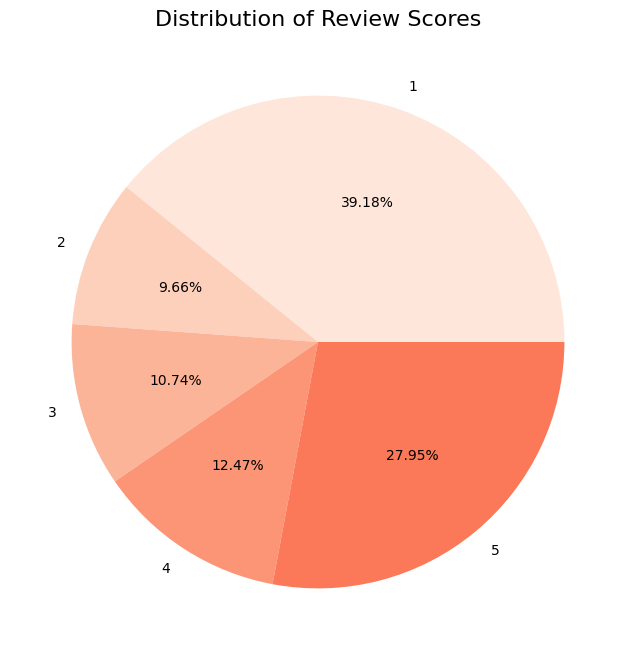

In [7]:
#Analysing score column
red_palette = sns.color_palette("Reds", 10)
score_counts = netflix_df['score'].value_counts().sort_index()
plt.figure(figsize=(8, 8))
plt.pie(score_counts, labels=score_counts.index, autopct='%1.2f%%', colors=red_palette)
plt.title('Distribution of Review Scores', fontsize=16)
plt.show()

In [8]:
#Changing into date format
netflix_df['at'] = pd.to_datetime(netflix_df['at'])
print(netflix_df['at'].dtype)
netflix_df

datetime64[ns]


,reviewId,userName,content,score,thumbsUpCount,at
0,b7f2ea02-87f9-4703-99c0-2a5da1550ed0,Sahara Gonna,I can't log in I have to pay it but I pay it s...,1,0,2024-05-13 23:35:28
1,1e93bd7d-2e5e-449d-a304-afa0212afcf5,Kaylee Neel,I love Netflix is so good I love it so much,5,0,2024-05-13 23:00:54
2,afd72658-f2b1-4424-80cb-0f4ed7f138c1,Emad Moadamani,Good,3,0,2024-05-13 22:45:29
3,87833ccb-386c-4c66-bbd3-361a733ad974,lucas Duarte,This was good when people could actually use i...,1,0,2024-05-13 22:29:59
4,a67ae2d4-da9e-4b4a-9195-533d4ff00d37,Evynn Leus-Ross,"Was working perfectly up until last month, it ...",1,0,2024-05-13 22:27:17
...,...,...,...,...,...,...
108489,a760ead9-e7aa-4ed1-a651-5c37c3600dac,A Google user,i really like it! there are so many movies and...,5,0,2019-08-03 15:06:03
108490,4957f9e7-d7f4-4a52-9764-031cebcac83f,Captain Jeoy,I love Netflix. I always enjoy my time using it.,5,0,2022-08-15 16:16:30
108491,9acf7586-7abf-4b50-8c50-3ede3b2a42c4,Suryansh,Sound quality is very slow of movies,1,0,2020-08-17 07:26:58
108492,32870f7f-c461-4256-b602-75244ca60248,A Google user,Rate is very expensive.. bcos we see netflix s...,1,0,2019-07-21 09:41:42


#### Text Preprocessing

In [9]:
#Remove puncuation
netflix_df["content"] = netflix_df["content"].astype(str).apply(lambda x : re.sub('[,\\.?!]', '', x))

In [10]:
#Convert to lowercase
netflix_df["content"] = netflix_df["content"].astype(str).apply(lambda x: x.lower())
print(netflix_df["content"].apply(str).head()) 

0    i can't log in i have to pay it but i pay it s...
1          i love netflix is so good i love it so much
2                                                 good
3    this was good when people could actually use i...
4    was working perfectly up until last month it n...
Name: content, dtype: object


#### Tokenization

In [11]:
def sent_to_words(sentences):
 for sentence in sentences:
     yield(gensim.utils.simple_preprocess(str(sentence), deacc=False)) 
#deacc=True removes punctuations
#data = imdb_df['review'].tolist()
data = netflix_df["content"][0:1000].tolist()
data_words = list(sent_to_words(data))
print('data_words[:1]', data_words)

data_words[:1] [['can', 'log', 'in', 'have', 'to', 'pay', 'it', 'but', 'pay', 'it', 'still', 'can', 'log', 'in'], ['love', 'netflix', 'is', 'so', 'good', 'love', 'it', 'so', 'much'], ['good'], ['this', 'was', 'good', 'when', 'people', 'could', 'actually', 'use', 'it', 'it', 'just', 'trash', 'now', 'you', 'think', 'in', 'this', 'economy', 'people', 'can', 'pay', 'full', 'subscription', 'the', 'one', 'thing', 'could', 'use', 'to', 'distract', 'myself', 'from', 'an', 'awfull', 'job', 'and', 'now', 'it', 'gone', 'thanks', 'lot', 'netflix', 'in', 'the', 'end', 'everyone', 'is', 'greedy', 'you', 'can', 'even', 'put', 'out', 'decent', 'series', 'anymore'], ['was', 'working', 'perfectly', 'up', 'until', 'last', 'month', 'it', 'now', 'stays', 'on', 'the', 'loading', 'screen', 'and', 'tells', 'me', 'there', 'an', 'error', 've', 'tried', 'everything', 'and', 'it', 'still', 'doesn', 'work', 'hoping', 'it', 'll', 'fix', 'itself', 'soon'], ['neither', 'the', 'app', 'on', 'my', 'tv', 'nor', 'my', 'ph

#### Lemmatisation and Stop Words

In [12]:
from gensim.parsing.preprocessing import STOPWORDS
my_stop_words = STOPWORDS.union(set(['but']))
#Define functions for stopwords, bigrams, trigrams and lemmatisation
def remove_stopwords(texts):
 return [[word for word in simple_preprocess(str(doc)) if word not in
my_stop_words] for doc in texts]

In [13]:
def make_bigrams(texts):
 return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
 return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [14]:
#Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=80) 
#Higher threshold fewer phrases
print('bigram',bigram)
print('bigram data',bigram[data_words])
trigram = gensim.models.Phrases(bigram[data_words], threshold=80)
print('trigram',trigram)
#Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
bigram_mod.save("bigram_mod")
trigram_mod.save("trigram_mod")
bigram_mod = gensim.models.Phrases.load("bigram_mod")
trigram_mod = gensim.models.Phrases.load("trigram_mod")

bigram Phrases<11238 vocab, min_count=5, threshold=80, max_vocab_size=40000000>
bigram data <gensim.interfaces.TransformedCorpus object at 0x29e8ee6f0>
trigram Phrases<11240 vocab, min_count=5, threshold=80, max_vocab_size=40000000>


In [15]:
#Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
#Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [16]:
#use the Spacy library to train a lemmatiser from my bigram data
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
 """https://spacy.io/api/annotation"""
 texts_out = []
 for sent in texts:
     doc = nlp(" ".join(sent)) 
     texts_out.append([token.lemma_ for token in doc if token.pos_ in
allowed_postags])
 return texts_out

In [17]:
#Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
#Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 
'ADJ', 'VERB', 'ADV'])
print('data_lemmatized[:1]', data_lemmatized) 

data_lemmatized[:1] [['log', 'pay', 'pay', 'log'], ['love', 'good', 'love'], ['good'], ['good', 'people', 'actually', 'use', 'trash', 'think', 'economy', 'people', 'pay', 'subscription', 'thing', 'use', 'distract', 'awfull', 'job', 'go', 'thank', 'lot', 'end', 'greedy', 'decent', 'series', 'anymore'], ['work', 'perfectly', 'month', 'stay', 'loading', 'screen', 'tell', 'error', 've', 'try', 'work', 'hope', 'fix', 'soon'], ['tv', 'phone', 'let', 'watch', 'show', 'think', 'household', 'pay', 'increase', 'subscription', 'terrible', 'business', 'model', 'planning', 'cancel', 'subscription'], ['win', 'play'], ['musician'], ['multiple', 'household', 'long', 'allow', 'little', 'explanation', 'clarity', 'go', 'quality', 'movie', 'show', 'available', 'keep', 'go', 'pay', 'subscription', 'long'], ['interesting', 'today', 'use', 'time', 'attract', 'people', 'view'], ['frustrating', 'brightness', 'fail', 'canadian', 'version', 'late', 'updateplease', 'fix'], ['stop', 'support', 'tv'], ['movie', 'go

### Exploratory Data Analysis (EDA)

#### Word Frequency Analysis / Word Cloud

In [18]:
from wordcloud import WordCloud
def getWordCloud(hashtags):
 # Read the whole text.
 text = ' '.join(hashtags)
 # Generate a word cloud image
 wordcloud = WordCloud().generate(text)
 # Display the generated image:
 # the matplotlib way:
 plt.imshow(wordcloud, interpolation='bilinear')
 plt.axis("off")
 # lower max_font_size
 wordcloud = WordCloud(max_font_size=40).generate(text)
 plt.figure()
 plt.imshow(wordcloud, interpolation="bilinear")
 plt.axis("off")
 plt.savefig('wordcloud_all.pdf', dpi=500) 
 plt.show()

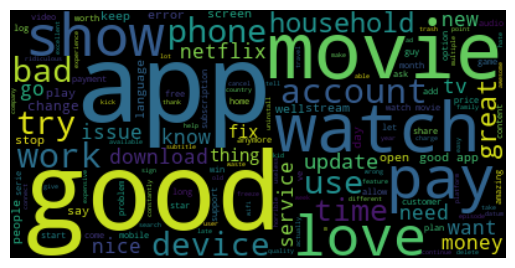

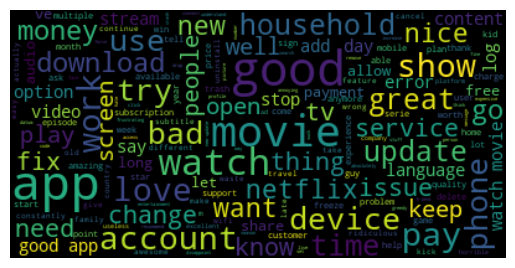

In [19]:
s = []
for l in data_lemmatized:
 t = ' '.join(l)
 s.append(t)
getWordCloud(s)

#### Sentiment Analysis

In [20]:
#Train sentiment analysis classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


#Extract 'content' (text) and 'score' (sentiment label) columns
X = netflix_df['content']
y = netflix_df['score']

#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()

#Vectorize the text data
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

#Train Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_dtm, y_train)

#Predict sentiment labels on test data
y_pred = classifier.predict(X_test_dtm)

#Evaluate classifier performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.6001659062629614

Classification Report:
              precision    recall  f1-score   support

           1       0.58      0.96      0.72      8448
           2       0.00      0.00      0.00      2143
           3       0.20      0.00      0.00      2374
           4       0.24      0.00      0.00      2721
           5       0.65      0.81      0.72      6013

    accuracy                           0.60     21699
   macro avg       0.33      0.36      0.29     21699
weighted avg       0.46      0.60      0.48     21699



/Users/meftahulzannat/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/meftahulzannat/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/meftahulzannat/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Feature Engineering

In [21]:
from sklearn.feature_selection import SelectKBest, chi2

#Split the DataFrame into positive and negative reviews
positive_df = netflix_df[netflix_df['score'] > 3]
negative_df = netflix_df[netflix_df['score'] <= 3]

#Add a new column indicating the sentiment label: 1 for positive, 0 for negative
positive_df['sentiment'] = 1
negative_df['sentiment'] = 0

#Combine positive and negative DataFrames back together
combined_df = pd.concat([positive_df, negative_df], ignore_index=True)

#Feature Engineering: create a feature indicating the length of the review text
combined_df['review_length'] = combined_df['content'].apply(lambda x: len(x))

#Extract features and target
X = combined_df[['content', 'review_length', 'sentiment']]
y = combined_df['score']

#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_text = vectorizer.fit_transform(X_train['content'])
X_test_text = vectorizer.transform(X_test['content'])

#Combine text features with engineered features
import scipy.sparse as sp
X_train_combined = sp.hstack((X_train_text, X_train[['review_length', 'sentiment']].values), format='csr')
X_test_combined = sp.hstack((X_test_text, X_test[['review_length', 'sentiment']].values), format='csr')

#Perform feature selection using chi-square test
k = 5000  # Adjust the number of features as needed
selector = SelectKBest(chi2, k=k)
X_train_combined_selected = selector.fit_transform(X_train_combined, y_train)
X_test_combined_selected = selector.transform(X_test_combined)

combined_df


/var/folders/9s/zvzy0msj62b8hdlt3hyzv5gh0000gn/T/ipykernel_30453/1973362688.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_df['sentiment'] = 1
/var/folders/9s/zvzy0msj62b8hdlt3hyzv5gh0000gn/T/ipykernel_30453/1973362688.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_df['sentiment'] = 0


,reviewId,userName,content,score,thumbsUpCount,at,sentiment,review_length
0,1e93bd7d-2e5e-449d-a304-afa0212afcf5,Kaylee Neel,i love netflix is so good i love it so much,5,0,2024-05-13 23:00:54,1,43
1,7c329a4d-daf6-4e0c-b6cc-fe8a8eef9cb2,mayar5 makuc1,this app has interesting me today because i di...,5,0,2024-05-13 21:43:24,1,115
2,67379bb7-aeae-4c90-9d35-774be8483040,George Krito,lots of movies to choose from never a dull moment,5,0,2024-05-13 20:51:44,1,49
3,181257bf-b066-4b3d-b32a-06cd3c83800c,italia swofford,verey good,5,0,2024-05-13 20:49:11,1,10
4,bf1b8be7-95f2-43d2-95a3-0c45109025ca,Onyedikachukwu John,it is the best for watching movies,5,0,2024-05-13 20:46:10,1,34
...,...,...,...,...,...,...,...,...
108489,5f68b545-1079-4a57-9024-fc6e27d7db96,AD Basson,the best app ever,2,0,2024-04-01 10:21:15,0,17
108490,9996579a-cf67-40a6-94eb-9ccd63c7d46a,dady mon mari,how can i delete one of the users please help me,3,0,2024-03-01 04:54:36,0,48
108491,cbb04dd9-1a1d-46df-80a4-8ae987fe5d85,Ciaran Worthington,everytime i watch a show it goes so dark so i ...,1,0,2020-08-22 14:58:10,0,60
108492,9acf7586-7abf-4b50-8c50-3ede3b2a42c4,Suryansh,sound quality is very slow of movies,1,0,2020-08-17 07:26:58,0,36


### Model Building

#### Traditional model 1: Multinomial Naive Bayes classifier

In [22]:
#Train Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train_combined_selected, y_train)

#Predict sentiment labels on test data
y_pred = classifier.predict(X_test_combined_selected)

#Evaluate classifier performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6910917553804323

Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.98      0.81      8476
           2       0.33      0.00      0.00      2023
           3       0.55      0.06      0.11      2308
           4       0.64      0.27      0.38      2715
           5       0.71      0.94      0.81      6177

    accuracy                           0.69     21699
   macro avg       0.58      0.45      0.42     21699
weighted avg       0.64      0.69      0.61     21699



#### Traditional model 2: Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

#Train Logistic Regression classifier
classifier = LogisticRegression(max_iter=3000)  
classifier.fit(X_train_combined_selected, y_train)

#Predict sentiment labels on test data
y_pred = classifier.predict(X_test_combined_selected)

#Evaluate classifier performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7279598138163049

Classification Report:
              precision    recall  f1-score   support

           1       0.74      0.95      0.83      8476
           2       0.23      0.03      0.05      2023
           3       0.55      0.40      0.46      2308
           4       0.65      0.49      0.56      2715
           5       0.80      0.89      0.84      6177

    accuracy                           0.73     21699
   macro avg       0.59      0.55      0.55     21699
weighted avg       0.68      0.73      0.69     21699



/Users/meftahulzannat/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Deep Learning Model 1: LSTM

In [26]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

In [39]:
#Tokenize the text data
max_features = 10000  # Maximum number of words to keep
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(combined_df['content'])
X = tokenizer.texts_to_sequences(combined_df['content'])

#Pad sequences to ensure uniform length
maxlen = 100  # Maximum sequence length
X = pad_sequences(X, maxlen=maxlen)

#Extract target
y = combined_df['score']

#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Build LSTM model
embedding_dim = 100  #Dimension of word embeddings
hidden_units = 64  #Number of hidden units in LSTM layer
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

#Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Train the model
batch_size = 32  # Batch size for training
epochs = 5  # Number of epochs
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

#Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)



Epoch 1/5


/Users/meftahulzannat/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2713/2713 ━━━━━━━━━━━━━━━━━━━━ 63s 23ms/step - accuracy: 0.3923 - loss: -95.1078 - val_accuracy: 0.3906 - val_loss: -337.6821
Epoch 2/5
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 61s 22ms/step - accuracy: 0.3917 - loss: -413.0977 - val_accuracy: 0.3906 - val_loss: -654.7549
Epoch 3/5
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 62s 23ms/step - accuracy: 0.3908 - loss: -726.2922 - val_accuracy: 0.3906 - val_loss: -971.4922
Epoch 4/5
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 61s 23ms/step - accuracy: 0.3896 - loss: -1041.9073 - val_accuracy: 0.3906 - val_loss: -1287.7909
Epoch 5/5
2713/2713 ━━━━━━━━━━━━━━━━━━━━ 60s 22ms/step - accuracy: 0.3910 - loss: -1354.4075 - val_accuracy: 0.3906 - val_loss: -1604.2830
679/679 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3946 - loss: -1601.0068
Test Accuracy: 0.3906170725822449


#### Deep Learning Model 2: GRU

In [40]:
from tensorflow.keras.layers import Embedding, GRU, Dense

#Tokenize the text data
max_features = 10000  # Maximum number of words to keep
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(combined_df['content'])
X = tokenizer.texts_to_sequences(combined_df['content'])

#Pad sequences to ensure uniform length
maxlen = 100  # Maximum sequence length
X = pad_sequences(X, maxlen=maxlen)

#Extract target
y = combined_df['score']

#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Define the model
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=128, input_length=maxlen))
model.add(GRU(units=64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

#Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Train the model
batch_size = 32  # Batch size for training
epochs = 5  # Number of epochs
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

#Evaluate the model
loss1, accuracy1 = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy1)



Epoch 1/5
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 61s 25ms/step - accuracy: 0.3882 - loss: -257400848384.0000 - val_accuracy: 0.3913 - val_loss: -274.5917
Epoch 2/5
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - accuracy: 0.3909 - loss: -1033959309312.0000 - val_accuracy: 0.3913 - val_loss: -525.5597
Epoch 3/5
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - accuracy: 0.3932 - loss: -1806650703872.0000 - val_accuracy: 0.3913 - val_loss: -780.6590
Epoch 4/5
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 61s 26ms/step - accuracy: 0.3910 - loss: -2586415202304.0000 - val_accuracy: 0.3913 - val_loss: -1035.6996
Epoch 5/5
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 62s 26ms/step - accuracy: 0.3914 - loss: -3383694721024.0000 - val_accuracy: 0.3913 - val_loss: -1294.0675
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3935 - loss: -1295.3656
Test Accuracy: 0.3913484215736389


### Model Optimization and Tuning

#### Multinomial Naive Bayes 

In [24]:
from sklearn.model_selection import GridSearchCV

#Define the Multinomial Naive Bayes classifier
classifier = MultinomialNB()

#Define hyperparameters grid for grid search
param_grid = {'alpha': [0.1, 0.5, 1.0]}

#Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_combined_selected, y_train)

#Get the best model from grid search
best_classifier = grid_search.best_estimator_

#Train the best model on the training data
best_classifier.fit(X_train_combined_selected, y_train)

#Predict sentiment labels on test data
y_pred = best_classifier.predict(X_test_combined_selected)

#Evaluate classifier performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.6964837089266787

Classification Report:
              precision    recall  f1-score   support

           1       0.70      0.97      0.81      8476
           2       0.19      0.01      0.01      2023
           3       0.55      0.13      0.21      2308
           4       0.61      0.35      0.45      2715
           5       0.72      0.91      0.81      6177

    accuracy                           0.70     21699
   macro avg       0.55      0.47      0.46     21699
weighted avg       0.63      0.70      0.63     21699



#### Logistic Regression Model Optimization

In [25]:
from sklearn.model_selection import GridSearchCV, cross_val_score
#Hyperparameter tuning with GridSearchCV
param_grid = {
    'penalty': ['l2'],  # L2 regularization
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'solver': ['lbfgs']  # Solver
}

#Initialize Logistic Regression model
logistic_model = LogisticRegression(max_iter=2000)

#GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_combined_selected, y_train)

#Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

#Train the classifier with the best parameters
best_classifier = grid_search.best_estimator_
best_classifier.fit(X_train_combined_selected, y_train)

#Predict sentiment labels on test data
y_pred = best_classifier.predict(X_test_combined_selected)

#Evaluate classifier performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#Cross-Validation
cv_scores = cross_val_score(best_classifier, X_train_combined_selected, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

/Users/meftahulzannat/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/meftahulzannat/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


/Users/meftahulzannat/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.726761601917139

Classification Report:
              precision    recall  f1-score   support

           1       0.74      0.94      0.83      8476
           2       0.26      0.03      0.06      2023
           3       0.54      0.41      0.46      2308
           4       0.64      0.51      0.57      2715
           5       0.80      0.88      0.84      6177

    accuracy                           0.73     21699
   macro avg       0.60      0.55      0.55     21699
weighted avg       0.68      0.73      0.69     21699



/Users/meftahulzannat/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/meftahulzannat/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Cross-Validation Scores: [0.72573305 0.72723083 0.72267988 0.72388962 0.72187338]
Mean Cross-Validation Score: 0.7242813526124776


/Users/meftahulzannat/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### LSTM

In [41]:
from keras.layers import LSTM, Dropout
from keras.optimizers import Adam

#Define LSTM model
embedding_dim = 100  #Dimension of word embeddings
hidden_units = 128  #Number of hidden units in LSTM layer
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

#Compile the model with a lower learning rate for better convergence
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#Train the model with an increased number of epochs
epochs = 10  #Number of epochs
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

#Evaluate the refined model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


Epoch 1/10
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 102s 43ms/step - accuracy: 0.3892 - loss: -155.6106 - val_accuracy: 0.3913 - val_loss: -558.2307
Epoch 2/10
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 100s 42ms/step - accuracy: 0.3913 - loss: -689.1282 - val_accuracy: 0.3913 - val_loss: -1092.0903
Epoch 3/10
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 100s 42ms/step - accuracy: 0.3921 - loss: -1214.7155 - val_accuracy: 0.3913 - val_loss: -1628.7440
Epoch 4/10
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 101s 42ms/step - accuracy: 0.3919 - loss: -1748.6965 - val_accuracy: 0.3913 - val_loss: -2166.0930
Epoch 5/10
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 100s 42ms/step - accuracy: 0.3950 - loss: -2273.5730 - val_accuracy: 0.3913 - val_loss: -2707.0605
Epoch 6/10
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 100s 42ms/step - accuracy: 0.3922 - loss: -2819.1045 - val_accuracy: 0.3913 - val_loss: -3246.1880
Epoch 7/10
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 105s 44ms/step - accuracy: 0.3925 - loss: -3359.3611 - val_accuracy: 0.3913 - val_loss: -3784.8928
Epoch 8/10
2374/

#### GRU

In [42]:
# Tokenize the text data
max_features = 10000  # Maximum number of words to keep
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(combined_df['content'])
X = tokenizer.texts_to_sequences(combined_df['content'])

# Pad sequences to ensure uniform length
maxlen = 100  # Maximum sequence length
X = pad_sequences(X, maxlen=maxlen)

# Extract target
y = combined_df['score']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the model
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=128, input_length=maxlen))
model.add(GRU(units=64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32  # Batch size for training
epochs = 10  # Number of epochs
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

Epoch 1/10
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 93s 39ms/step - accuracy: 0.3930 - loss: -10725006336.0000 - val_accuracy: 0.3913 - val_loss: -42.7151
Epoch 2/10
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.3920 - loss: -1483821952.0000 - val_accuracy: 0.3913 - val_loss: -56.4144
Epoch 3/10
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 90s 38ms/step - accuracy: 0.3945 - loss: -1201419392.0000 - val_accuracy: 0.3913 - val_loss: -72.5142
Epoch 4/10
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 92s 39ms/step - accuracy: 0.3938 - loss: -848179584.0000 - val_accuracy: 0.3913 - val_loss: -86.9625
Epoch 5/10
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.3920 - loss: -874752640.0000 - val_accuracy: 0.3913 - val_loss: -105.5843
Epoch 6/10
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.3918 - loss: -2095682304.0000 - val_accuracy: 0.3913 - val_loss: -122.3609
Epoch 7/10
2374/2374 ━━━━━━━━━━━━━━━━━━━━ 91s 38ms/step - accuracy: 0.3930 - loss: -1852781312.0000 - val_accuracy: 0.3913 - val_loss: 